In [1]:
import numpy as np
import random 
import gym

# import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd

from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

from models.TimeSeriesTransformer import *
from typing import List
from constants import *
from utils import *

In [2]:
# enable eager execution
tf.enable_eager_execution()

In [3]:
# seed random number generators for reproducable results
np.random.seed (0)
random.seed(0)
tf.set_random_seed(0)

# SAMPLE DATA

In [4]:
df = sample_data(episodes=200, seed=0)

# GENERATE PATTERN DATA

In [5]:
window_size=4

## Transformer 1 (1 percentile step)

In [6]:
t1_quantile_step = 1
bucket_df_t1 = create_quantiled_buckets(df=df, quantile_step=t1_quantile_step)

input_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL, ACTION]
target_col = [CART_POS, CART_VEL, PEND_POS, PEND_VEL]

train_data_t1, val_data_t1, input_shape_t1, mean_in_t1, std_in_t1, mean_out_t1, std_out_t1, x_train_multi_t1, y_train_multi_t1 = create_training_val_data(
                                                                            bucket_df_t1,
                                                                            input_cols=input_col, 
                                                                            target_cols=target_col,
                                                                            window_size=window_size,
                                                                            training_pattern_percent=0.7
                                                                        )

mean in = [50.49976969 50.49976969 50.49976969 50.49976969  0.50598802]
std in = [28.87631202 28.87631202 28.87631202 28.87631202  0.50002173]
mean out =  [50.49976969 50.49976969 50.49976969 50.49976969]
std out = [28.87631202 28.87631202 28.87631202 28.87631202]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (2479, 4, 5)
valData: number of trainingsexamples: (1063, 4, 5)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Input-Shape:  (4, 5)


## Transformer 2 (0.5 percentile step)

In [7]:
t2_quantile_step = 0.5
bucket_df_t2 = create_quantiled_buckets(df=df, quantile_step=t2_quantile_step)

train_data_t2, val_data_t2, input_shape_t2, mean_in_t2, std_in_t2, mean_out_t2, std_out_t2, x_train_multi_t2, y_train_multi_t2 = create_training_val_data(
                                                                            bucket_df_t2,
                                                                            input_cols=input_col, 
                                                                            target_cols=target_col,
                                                                            window_size=window_size,
                                                                            training_pattern_percent=0.7
                                                                        )

mean in = [100.49976969 100.49976969 100.49976969 100.49976969   0.50598802]
std in = [57.75438605 57.75438605 57.75438605 57.75438605  0.50002173]
mean out =  [100.49976969 100.49976969 100.49976969 100.49976969]
std out = [57.75438605 57.75438605 57.75438605 57.75438605]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (2479, 4, 5)
valData: number of trainingsexamples: (1063, 4, 5)
Input-Shape:  (4, 5)


## Transformer 3 (0.1 percentile step)

In [8]:
t3_quantile_step = 0.1
bucket_df_t3 = create_quantiled_buckets(df=df, quantile_step=t3_quantile_step)

train_data_t3, val_data_t3, input_shape_t3, mean_in_t3, std_in_t3, mean_out_t3, std_out_t3, x_train_multi_t3, y_train_multi_t3 = create_training_val_data(
                                                                            bucket_df_t3,
                                                                            input_cols=input_col, 
                                                                            target_cols=target_col,
                                                                            window_size=window_size,
                                                                            training_pattern_percent=0.7
                                                                        )

mean in = [500.49976969 500.49976969 500.49976969 500.49976969   0.50598802]
std in = [288.77602578 288.77602578 288.77602578 288.77602578   0.50002173]
mean out =  [500.49976969 500.49976969 500.49976969 500.49976969]
std out = [288.77602578 288.77602578 288.77602578 288.77602578]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (2479, 4, 5)
valData: number of trainingsexamples: (1063, 4, 5)
Input-Shape:  (4, 5)


# Create Transformer Model

In [9]:
def train_transformer(modelpath, train_data, val_data, num_layers, d_model, num_heads, dff, input_shape, max_epochs, steps_per_epoch, validation_steps, validation_freq):

    # Define callbacks
    es_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, restore_best_weights=True, verbose=1)
    #mc_trainLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}.bestTrainLoss", monitor='loss', verbose=1, save_best_only=True, mode='min')
    mc_valLoss_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f"{modelpath}/model.bestValLoss", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=r"./model_logs_tb", histogram_freq=1)

    # Ensure your model is defined
    model = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
    model.compile(optimizer='adam', loss='mse')

    # Fit the model
    history = model.fit(
        train_data,
        epochs=max_epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_data,
        validation_steps=validation_steps,
        validation_freq=validation_freq,
        callbacks=[
            #mc_trainLoss_callback,
            mc_valLoss_callback,
            es_callback, 
            #tensorboard_callback
        ]
    )

    # Save the model
    model.save(modelpath, save_format='tf')

    return history

In [10]:
# Transformer Parameters
num_layers = 2
d_model = 128
num_heads = 8
dff = 512
input_shape = (50, 4, 5)

pos_encoding = positional_encoding(50, d_model)

max_epochs = 1000
steps_per_epoch = 100
validation_steps = 100
validation_freq = 1

## Transformer 1 (1 percentile step)

In [11]:
# Define model parameters
modelpath_transformer_1 = "trained_models/transformer_model_1"

history_t1 = train_transformer(
    modelpath=modelpath_transformer_1,
    train_data=train_data_t1,
    val_data=val_data_t1,
    num_layers=num_layers,
    d_model=d_model, 
    num_heads=num_heads, 
    dff=dff, 
    input_shape=input_shape, 
    max_epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_freq=validation_freq
)


Train for 100 steps, validate for 100 steps
Epoch 1/1000
 96/100 [===========================>..] - ETA: 0s - loss: 1819.5185
Epoch 00001: val_loss improved from inf to 322855.24969, saving model to trained_models/transformer_model_1/model.bestValLoss
100/100 [==============================] - 3s 28ms/step - loss: 1801.9236 - val_loss: 322855.2497
Epoch 2/1000
 99/100 [============================>.] - ETA: 0s - loss: 1110.0951
Epoch 00002: val_loss improved from 322855.24969 to 308881.68125, saving model to trained_models/transformer_model_1/model.bestValLoss
100/100 [==============================] - 1s 10ms/step - loss: 1107.7963 - val_loss: 308881.6813
Epoch 3/1000
 98/100 [============================>.] - ETA: 0s - loss: 946.2663
Epoch 00003: val_loss improved from 308881.68125 to 308324.34500, saving model to trained_models/transformer_model_1/model.bestValLoss
100/100 [==============================] - 1s 10ms/step - loss: 946.8998 - val_loss: 308324.3450
Epoch 4/1000
 94/100 [

KeyboardInterrupt: 

## Transformer 2

In [ ]:
# Define model parameters
modelpath_transformer_2 = "trained_models/transformer_model_2"

history_t2 = train_transformer(
    modelpath=modelpath_transformer_2,
    train_data=train_data_t2,
    val_data=val_data_t2,
    num_layers=num_layers,
    d_model=d_model, 
    num_heads=num_heads, 
    dff=dff, 
    input_shape=input_shape, 
    max_epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_freq=validation_freq
)

Train for 100 steps, validate for 100 steps
Epoch 1/1000
 99/100 [============================>.] - ETA: 0s - loss: 9982.3695 
Epoch 00001: val_loss improved from inf to 8525.25837, saving model to trained_models/transformer_model_2/model.bestValLoss
100/100 [==============================] - 3s 26ms/step - loss: 9967.8925 - val_loss: 8525.2584
Epoch 2/1000
 98/100 [============================>.] - ETA: 0s - loss: 7142.5676
Epoch 00002: val_loss improved from 8525.25837 to 5815.60551, saving model to trained_models/transformer_model_2/model.bestValLoss
100/100 [==============================] - 1s 13ms/step - loss: 7124.5961 - val_loss: 5815.6055
Epoch 3/1000
 98/100 [============================>.] - ETA: 0s - loss: 4969.2034
Epoch 00003: val_loss improved from 5815.60551 to 4268.90032, saving model to trained_models/transformer_model_2/model.bestValLoss
100/100 [==============================] - 1s 12ms/step - loss: 4955.1759 - val_loss: 4268.9003
Epoch 4/1000
 96/100 [=============

## Transformer 3 (0.5 percentile step)

In [ ]:
# Define model parameters
modelpath_transformer_3 = "trained_models/transformer_model_3"

history_t3 = train_transformer(
    modelpath=modelpath_transformer_3,
    train_data=train_data_t3,
    val_data=val_data_t3,
    num_layers=num_layers,
    d_model=d_model, 
    num_heads=num_heads, 
    dff=dff, 
    input_shape=input_shape, 
    max_epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_freq=validation_freq
)

TypeError: train_transformer() got an unexpected keyword argument 'train_data'

# Evaluate model quality

### Sample new data from environment and determine episode with most steps

In [ ]:
dfEval = sample_data(episodes=100, seed=111)
dfEval.describe()
row_max_steps = dfEval[dfEval.step == dfEval.step.max()]
dfEval = dfEval[dfEval.episode==int(row_max_steps.episode)]

## Transformer 1 (5 percentile step)

### Extract prediction bounds from training data

In [ ]:
output_min_t1 = y_train_multi_t1.min(axis=0)
output_max_t1 = y_train_multi_t1.max(axis=0)
print ("min(output)_data: ", output_min_t1)
print ("max(output)_data: ", output_max_t1)

min(output)_data:  [0. 0. 0. 0.]
max(output)_data:  [100. 100. 100. 100.]


### Evaluate transformer

In [ ]:
# Define custom objects dictionary
custom_objects = {
    'TimeSeriesTransformer': TimeSeriesTransformer,
    'Encoder': Encoder,
    'EncoderLayer': EncoderLayer,
    'MultiHeadAttention': MultiHeadAttention,
    'point_wise_feed_forward_network': point_wise_feed_forward_network
}

min(output)_data:  [0. 0. 0. 0.]
max(output)_data:  [100. 100. 100. 100.]
Bound-hit at step:  4  => terminating further evaluation


KeyError: 'cartPos'

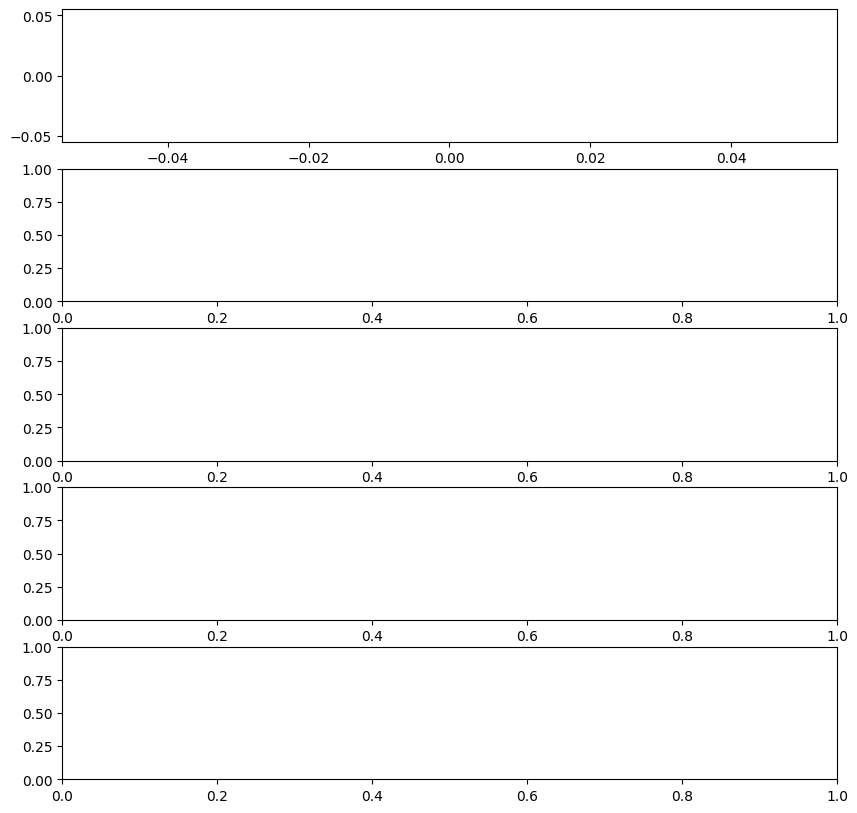

In [ ]:
output_min_t1 = y_train_multi_t1.min(axis=0)
output_max_t1 = y_train_multi_t1.max(axis=0)
print ("min(output)_data: ", output_min_t1)
print ("max(output)_data: ", output_max_t1)

# Load the saved model with custom objects
transformer_model_t1 = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
transformer_model_t1.load_weights(f"./{modelpath_transformer_1}/model.bestValLoss")
#lstm_model = tf.keras.models.load_model("model.h5")

dfEval_t1 = create_quantiled_buckets(df=dfEval, quantile_step=t1_quantile_step)

dfNet_t1 = evaluate_transformer(
    transformer_model=transformer_model_t1,
    dfEval=dfEval_t1,
    window_size=window_size,
    output_max=output_max_t1,
    output_min=output_min_t1
)

plot_evaluation(
    dfNet=dfNet_t1,
    dfEval=dfEval_t1,
    window_size=window_size,
)

# Transformer 2

min(output)_data:  [0. 0. 1. 0.]
max(output)_data:  [200. 200. 200. 200.]
[[[ 82.       135.       143.        66.         0.      ]
  [103.       107.       123.        94.         1.      ]
  [ 98.       131.       127.        70.         1.      ]
  [118.47163  133.25865  103.29062   70.430016   1.      ]]]


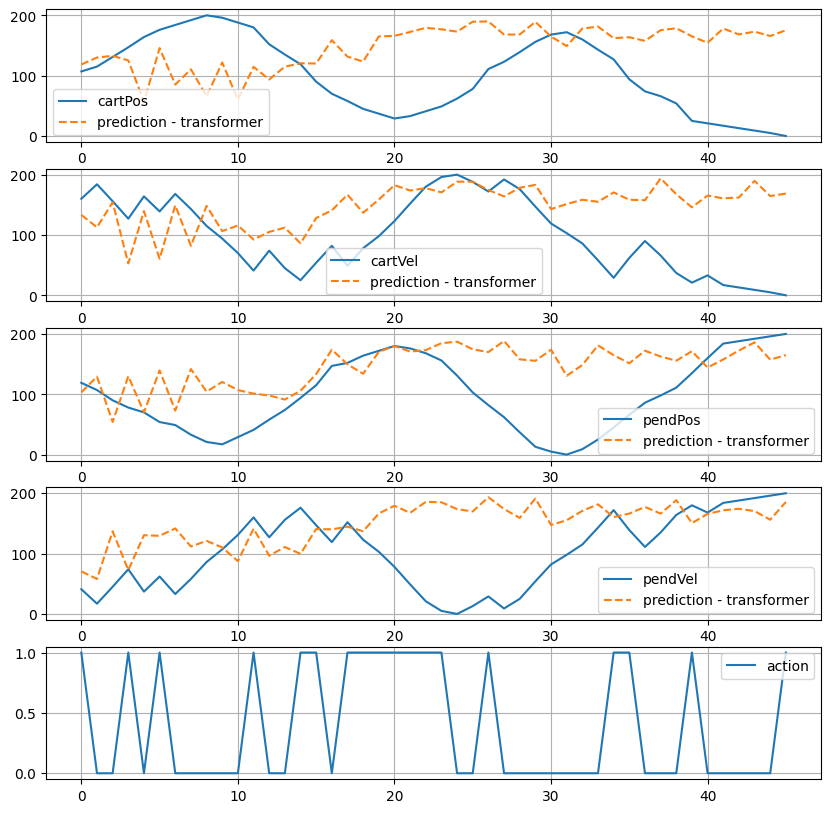

In [ ]:
output_min_t2 = y_train_multi_t2.min(axis=0)
output_max_t2 = y_train_multi_t2.max(axis=0)
print ("min(output)_data: ", output_min_t2)
print ("max(output)_data: ", output_max_t2)

# Load the saved model with custom objects
transformer_model_t2 = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
transformer_model_t2.load_weights(f"./{modelpath_transformer_2}/model.bestValLoss")
#lstm_model = tf.keras.models.load_model("model.h5")

dfEval_t2 = create_quantiled_buckets(df=dfEval, quantile_step=t2_quantile_step)

dfNet_t2 = evaluate_transformer(
    transformer_model=transformer_model_t2,
    dfEval=dfEval_t2,
    window_size=window_size,
    output_max=output_max_t2,
    output_min=output_min_t2
)

plot_evaluation(
    dfNet=dfNet_t2,
    dfEval=dfEval_t2,
    window_size=window_size,
)

# Transformer 3

min(output)_data:  [0. 0. 0. 0.]
max(output)_data:  [200. 200. 200. 200.]
[[[409.      674.      715.      327.        0.     ]
  [511.      531.      613.      470.        1.     ]
  [490.      654.      633.      347.        1.     ]
  [142.07156 143.7175  147.00504 157.78502   1.     ]]]


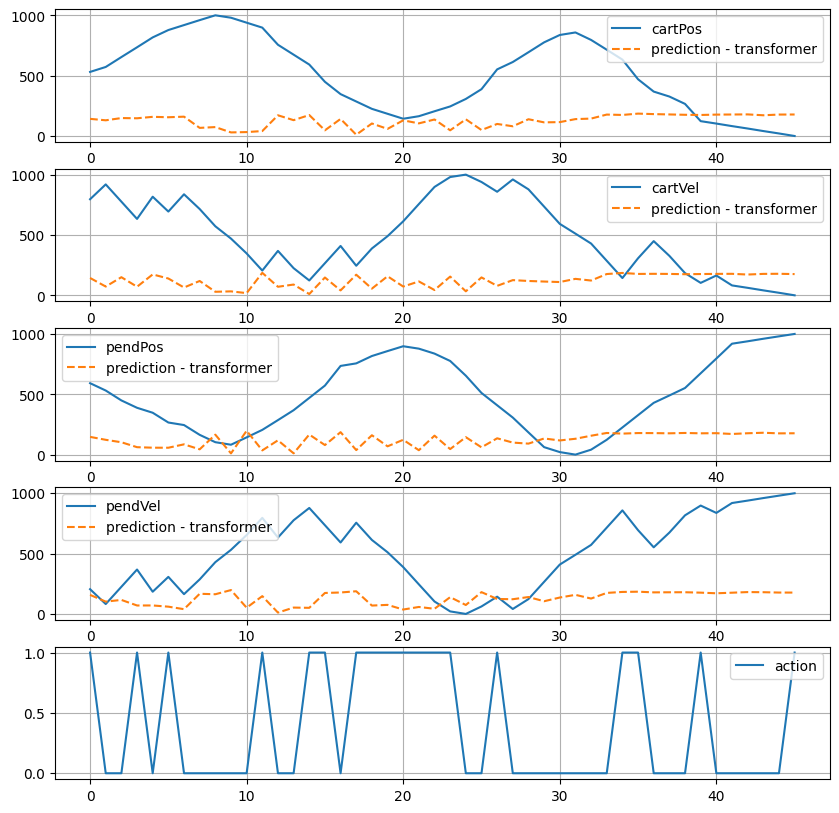

In [ ]:
output_min_t3 = y_train_multi_t3.min(axis=0)
output_max_t3 = y_train_multi_t3.max(axis=0)
print ("min(output)_data: ", output_min_t3)
print ("max(output)_data: ", output_max_t3)

# Load the saved model with custom objects
transformer_model_t3 = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
transformer_model_t3.load_weights(f"./{modelpath_transformer_3}/model.bestValLoss")
#lstm_model = tf.keras.models.load_model("model.h5")

dfEval_t3 = create_quantiled_buckets(df=dfEval, quantile_step=t3_quantile_step)

dfNet_t3 = evaluate_transformer(
    transformer_model=transformer_model_t3,
    dfEval=dfEval_t3,
    window_size=window_size,
    output_max=output_max_t3,
    output_min=output_min_t3
)

plot_evaluation(
    dfNet=dfNet_t3,
    dfEval=dfEval_t3,
    window_size=window_size,
)

# Train and Evaluate Transformer without any buckets

In [ ]:
train_data_t4, val_data_t4, input_shape_t4, mean_in_t4, std_in_t4, mean_out_t4, std_out_t4, x_train_multi_t4, y_train_multi_t4 = create_training_val_data(
                                                                            df,
                                                                            input_cols=input_col, 
                                                                            target_cols=target_col,
                                                                            window_size=window_size,
                                                                            training_pattern_percent=0.7
                                                                        )

mean in = [ 3.57404071e-04  3.49499894e-02  3.10294488e-03 -3.09609093e-02
  5.10799632e-01]
std in = [0.09018948 0.54863942 0.09019783 0.79945598 0.4999408 ]
mean out =  [ 0.0003574   0.03494999  0.00310294 -0.03096091]
std out = [0.09018948 0.54863942 0.09019783 0.79945598]
trainData: Single window of past history : (4, 5)
trainData: Single window of future : (4,)
valData: Single window of past history : (4, 5)
valData: Single window of future : (4,)
trainData: number of trainingsexamples: (2486, 4, 5)
valData: number of trainingsexamples: (1066, 4, 5)
Input-Shape:  (4, 5)


In [ ]:
# Define model parameters
modelpath_transformer_4 = "trained_models/transformer_model_4"

history_t4 = train_transformer(
    modelpath=modelpath_transformer_4,
    train_data=train_data_t4,
    val_data=val_data_t4,
    num_layers=num_layers,
    d_model=d_model, 
    num_heads=num_heads, 
    dff=dff, 
    input_shape=input_shape, 
    max_epochs=max_epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    validation_freq=validation_freq
)

Train for 100 steps, validate for 100 steps
Epoch 1/1000
 94/100 [===========================>..] - ETA: 0s - loss: 10291.1818
Epoch 00001: val_loss improved from inf to 8486.17535, saving model to trained_models/transformer_model_4/model.bestValLoss
100/100 [==============================] - 3s 28ms/step - loss: 10193.2041 - val_loss: 8486.1754
Epoch 2/1000
 96/100 [===========================>..] - ETA: 0s - loss: 7373.2021
Epoch 00002: val_loss improved from 8486.17535 to 5810.39113, saving model to trained_models/transformer_model_4/model.bestValLoss
100/100 [==============================] - 1s 12ms/step - loss: 7321.9728 - val_loss: 5810.3911
Epoch 3/1000
 97/100 [============================>.] - ETA: 0s - loss: 5061.0175
Epoch 00003: val_loss improved from 5810.39113 to 4264.22746, saving model to trained_models/transformer_model_4/model.bestValLoss
100/100 [==============================] - 1s 12ms/step - loss: 5038.1104 - val_loss: 4264.2275
Epoch 4/1000
 99/100 [============

In [ ]:
def evaluate_transformer(transformer_model, dfEval, window_size, output_min, output_max):
    # FIFO-buffer that keeps the neural state
    stateBuffer = collections.deque(maxlen=window_size)

    # outputs of neural network will be stored here
    transitions = []

    for i in range (len(dfEval)): 
                                
        # estimation of first state
        if i < window_size: 
            state_data = np.float32([dfEval[CART_POS].values[i], dfEval[CART_VEL].values[i],
                                dfEval[PEND_POS].values[i], dfEval[PEND_VEL].values[i],
                                dfEval[ACTION].values[i]])
            stateBuffer.append(state_data)
            #print ("Filling initState: %s" % state_data)
        
        # predict successor state
        else: 
            
            ###########################
            # recall of neural network
            ###########################
            state = np.array([list(stateBuffer)])
            if i==5:
                print (state)
            
            netOutput = transformer_model.predict(np.float32(state))[0]
            
            # clip output to observed data bounds
            netOutput = np.clip(netOutput, output_min, output_max)
            
            # check if value bound was hit
            if np.any(netOutput == output_min) or np.any(netOutput == output_max):
                print(netOutput)
                print ("Bound-hit at step: ", i, " => terminating further evaluation")
                break
            
            # append plotting data
            transitions.append ({
                CART_POS:netOutput[0], CART_VEL:netOutput[1],
                PEND_POS:netOutput[2], PEND_VEL:netOutput[3]
            })
            
            # update RNN state
            stateBuffer.append(np.float32([netOutput[0], netOutput[1], 
                                        netOutput[2], netOutput[3], 
                                        dfEval[ACTION].values[i]]))
            
    dfNet = pd.DataFrame(transitions)

    return dfNet

min(output)_data:  [-0.9430517  -2.064328   -0.20932531 -2.6834183 ]
max(output)_data:  [0.61611664 1.7560351  0.20927136 2.6492236 ]


[0.61611664 1.7560351  0.20927136 2.6492236 ]
Bound-hit at step:  4  => terminating further evaluation


KeyError: 'cartPos'

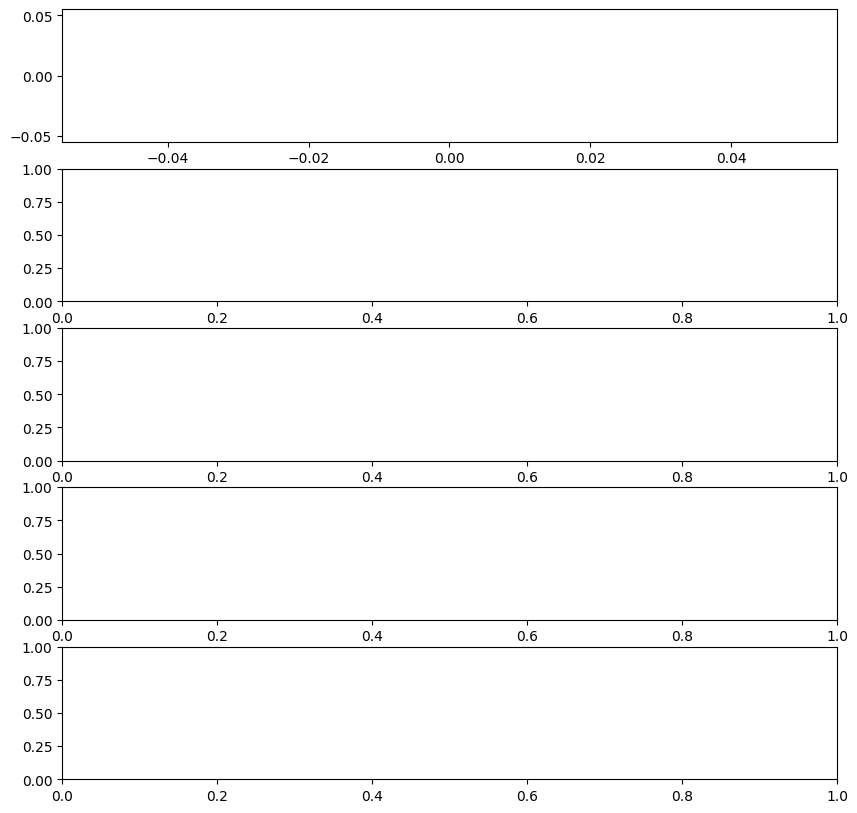

In [ ]:
output_min_t4 = y_train_multi_t4.min(axis=0)
output_max_t4 = y_train_multi_t4.max(axis=0)
print ("min(output)_data: ", output_min_t4)
print ("max(output)_data: ", output_max_t4)

# Load the saved model with custom objects
transformer_model_t4 = TimeSeriesTransformer(num_layers, d_model, num_heads, dff, input_shape)
transformer_model_t4.load_weights(f"./{modelpath_transformer_4}/model.bestValLoss")

dfNet_t4 = evaluate_transformer(
    transformer_model=transformer_model_t4,
    dfEval=dfEval,
    window_size=window_size,
    output_max=output_max_t4,
    output_min=output_min_t4
)

plot_evaluation(
    dfNet=dfNet_t4,
    dfEval=dfEval,
    window_size=window_size,
)

In [ ]:
output_max_t4, output_min_t4

(array([0.61611664, 1.7560351 , 0.20927136, 2.6492236 ], dtype=float32),
 array([-0.9430517 , -2.064328  , -0.20932531, -2.6834183 ], dtype=float32))